In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.REPClassifier import REPClassifier
from src.utils.StandardDataset import StandardDataset
from src.utils.perturbations import *

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

In [5]:
mnist_trainset = datasets.MNIST(root=ROOT+"src/data", train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root=ROOT+"src/data", train=False, download=True, transform=ToTensor())

train_data = mnist_trainset.data.numpy()
train_labels = mnist_trainset.targets.numpy()
test_data = mnist_testset.data.numpy()
test_labels = mnist_testset.targets.numpy()
print(len(train_data), len(test_data))

train_val_split = 0.85
test_split = 0

trainset = StandardDataset(train_data, train_labels, train_val_split)
testset = StandardDataset(test_data, test_labels, test_split)

60000 10000


In [14]:
# Define the perturbation functions
perturbations = [
    gaussian_noise_perturbation(std=2.5),
    gaussian_noise_perturbation(std=5),
    laplacian_noise_perturbation(scale=2),
    laplacian_noise_perturbation(scale=4),
    lp_norm_perturbation(epsilon=50, p=2),
    lp_norm_perturbation(epsilon=100, p=2),
    # lpips_perturbation(std=5),
]

shuffle = True
include_original = True

pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))

# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 32] # must start with a 1 and be at least length--2
linear_sizes = [64, 32]
kernel = 3
model = REPClassifier(channel_widths, linear_sizes, kernel, pool_fcn, 
                      perturbations, include_original, shuffle, 
                      nonlinearity=nn.ReLU(), num_classes=10)

In [13]:
config = {'lr': 1e-3,
          'n_epochs': 5,
          'batch_size': 64}
verbose = True # print metrics during training, False for no printing
model.train_model(trainset, config)

Epoch 1/5: (Train) Loss = 2.7655e+00, Acc = 0.1090, (Val) Loss = 2.2995e+00, Acc = 0.1210
Epoch 2/5: (Train) Loss = 2.2970e+00, Acc = 0.1181, (Val) Loss = 2.2919e+00, Acc = 0.1324
Epoch 3/5: (Train) Loss = 2.1722e+00, Acc = 0.1823, (Val) Loss = 1.9871e+00, Acc = 0.2221
Epoch 4/5: (Train) Loss = 1.9144e+00, Acc = 0.2594, (Val) Loss = 2.0075e+00, Acc = 0.2210
Epoch 5/5: (Train) Loss = 1.7814e+00, Acc = 0.3055, (Val) Loss = 1.6515e+00, Acc = 0.3560


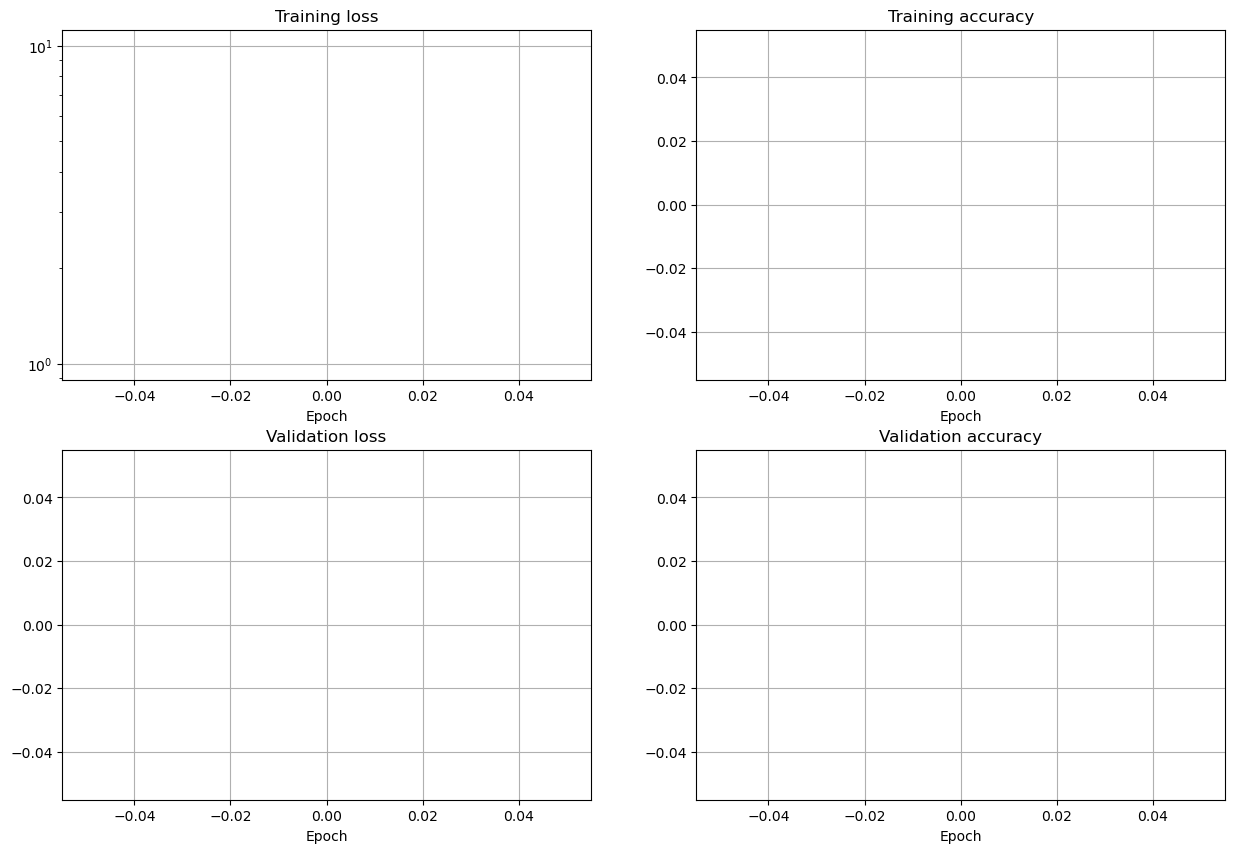

In [15]:
# plot training/validation loss and accuracy over training time
model.plot_model_results()

In [ ]:
model_name = 'some_perturbations_01'
model.save_model(ROOT + 'src/models/' + model_name + '.pt')